# CEE 501 - HW5: Traffic Sign Classification using Neural Networks

## German Traffic Sign Recognition Dataset (GTSRB)

This notebook implements and compares two approaches:
- **Problem 1**: Artificial Neural Network (ANN)
- **Problem 2**: Convolutional Neural Network (CNN)

Dataset: 43 categories of traffic signs
- Training: 39,209 images
- Test: 12,630 images
- Size: 32x32x3 (RGB)

## Google Colab Environment Setup

This notebook automatically detects if running on Google Colab and mounts Google Drive if needed.

In [1]:
import os
import sys

# Detect if running in Google Colab
IS_COLAB = 'google.colab' in sys.modules

if IS_COLAB:
    print("✓ Google Colab environment detected!")
    print("Mounting Google Drive...")

    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

    # Navigate to the HW5 folder
    hw5_path = '/content/drive/My Drive/CEE_501/HW_5'

    if os.path.exists(hw5_path):
        os.chdir(hw5_path)
        print(f"✓ Successfully mounted and navigated to: {hw5_path}")
        print(f"✓ Current working directory: {os.getcwd()}")
    else:
        print(f"⚠ Warning: Path '{hw5_path}' not found in Google Drive")
        print(f"  Available drives: {os.listdir('/content/drive/My Drive')[:10]}")
else:
    print("✓ Local environment detected (not Google Colab)")
    print(f"✓ Current working directory: {os.getcwd()}")


✓ Google Colab environment detected!
Mounting Google Drive...
Mounted at /content/drive
✓ Successfully mounted and navigated to: /content/drive/My Drive/CEE_501/HW_5
✓ Current working directory: /content/drive/My Drive/CEE_501/HW_5


## WSL Ubuntu Environment Setup

This notebook uses **WSL Ubuntu** with Python 3.12.3 to avoid Windows compatibility issues.

All required packages are pre-installed. If running locally, install with:
```bash
python3 -m pip install torch keras scipy scikit-learn matplotlib numpy jupyter ipykernel
```

## Check and Install Dependencies

First, let's verify all packages are available.

In [2]:
import subprocess
import sys

def check_and_install(package_name, import_name=None):
    """Check if a package is installed, and install it if missing."""
    if import_name is None:
        import_name = package_name

    try:
        __import__(import_name)
        print(f"✓ {package_name} is already installed")
        return True
    except ImportError:
        print(f"✗ {package_name} not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "-q"])
            print(f"✓ {package_name} installed successfully")
            return True
        except subprocess.CalledProcessError:
            print(f"✗ Failed to install {package_name}")
            return False

# List of required packages
required_packages = [
    ("torch", "torch"),
    ("torchvision", "torchvision"),
    ("keras", "keras"),
    ("scipy", "scipy"),
    ("scikit-learn", "sklearn"),
    ("matplotlib", "matplotlib"),
    ("numpy", "numpy")
]

print("Checking required dependencies...")
print("=" * 60)

all_installed = True
for package, import_name in required_packages:
    if not check_and_install(package, import_name):
        all_installed = False

print("=" * 60)
if all_installed:
    print("✓ All dependencies are installed!")
else:
    print("✗ Some dependencies failed to install. Please install manually.")

print("\nYou can now proceed with the rest of the notebook.")

Checking required dependencies...
✓ torch is already installed
✓ torchvision is already installed
✓ keras is already installed
✓ scipy is already installed
✓ scikit-learn is already installed
✓ matplotlib is already installed
✓ numpy is already installed
✓ All dependencies are installed!

You can now proceed with the rest of the notebook.


## Check GPU Availability

In [3]:
import torch
import subprocess
import platform

print("=" * 70)
print("GPU DIAGNOSTICS & TROUBLESHOOTING")
print("=" * 70)

# 1. Check CUDA availability
print("\n1. PyTorch CUDA Check:")
print(f"   torch.cuda.is_available(): {torch.cuda.is_available()}")
print(f"   PyTorch Version: {torch.__version__}")

# 2. Check NVIDIA GPU hardware
print("\n2. NVIDIA GPU Hardware Detection:")
try:
    if platform.system() == "Windows":
        result = subprocess.run(['nvidia-smi'], capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            # Extract key info from nvidia-smi output
            lines = result.stdout.split('\n')
            for line in lines:
                if 'NVIDIA-SMI' in line or 'Driver Version' in line or 'CUDA Version' in line or 'GPU' in line:
                    print(f"   {line.strip()}")
            print("   ✓ nvidia-smi found - GPU hardware detected")
        else:
            print("   ✗ nvidia-smi command failed")
    else:
        print("   (nvidia-smi check not available on this OS)")
except Exception as e:
    print(f"   ✗ Could not run nvidia-smi: {str(e)}")

# 3. Detailed CUDA Info
print("\n3. CUDA/cuDNN Information:")
print(f"   CUDA Available: {torch.cuda.is_available()}")
print(f"   CUDA Version: {torch.version.cuda}")
print(f"   cuDNN Version: {torch.backends.cudnn.version()}")
print(f"   cuDNN Enabled: {torch.backends.cudnn.enabled}")
print(f"   GPU Count: {torch.cuda.device_count()}")

# 4. GPU Details if available
if torch.cuda.is_available():
    print("\n4. GPU Details:")
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"   GPU {i}: {props.name}")
        print(f"   - Compute Capability: {props.major}.{props.minor}")
        print(f"   - Total Memory: {props.total_memory / 1024**3:.2f} GB")
        print(f"   - Multi-Processor Count: {props.multi_processor_count}")
else:
    print("\n4. GPU Status: ✗ NOT DETECTED")

# 5. GPU Computation Test
print("\n5. GPU Computation Test:")
try:
    if torch.cuda.is_available():
        # Test tensor creation and computation
        test_tensor = torch.randn(1000, 1000).cuda()
        result = torch.mm(test_tensor, test_tensor)
        print("   ✓ GPU computation test PASSED")
        device = torch.device("cuda")
    else:
        print("   ⚠ Skipping GPU computation test (GPU not available)")
        device = torch.device("cpu")
except RuntimeError as e:
    print(f"   ✗ GPU computation test FAILED: {str(e)}")
    device = torch.device("cpu")

# 6. Troubleshooting suggestions
print("\n6. Troubleshooting Steps:")
if torch.cuda.is_available():
    print("   ✓ GPU is working! Keras will use GPU for training.")
else:
    print("   ✗ GPU not available. Try these steps:")
    print("")
    print("   Step 1: Verify NVIDIA GPU exists")
    print("   > Open PowerShell and run: nvidia-smi")
    print("   > If command not found, GPU drivers may not be installed")
    print("")
    print("   Step 2: Check CUDA installation")
    print("   > Run: nvidia-smi")
    print("   > Look for 'CUDA Version' line (should show 12.1 or compatible)")
    print("")
    print("   Step 3: Verify PyTorch-CUDA compatibility")
    print("   > Current CUDA Version: {}".format(torch.version.cuda))
    print("   > Reinstall PyTorch with matching CUDA:")
    print("   > pip uninstall torch torchvision torchaudio -y")
    print("   > pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121")
    print("")
    print("   Step 4: Check environment variables (PowerShell)")
    print("   > $env:CUDA_PATH")
    print("   > $env:PATH | Select-String 'cuda'")
    print("")
    print("   Step 5: Verify cuDNN installation")
    print("   > Download from: https://developer.nvidia.com/cudnn")
    print("   > Extract to CUDA installation directory (usually C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v12.1)")

print("\n" + "=" * 70)
print(f"Current Device: {device}")
print("=" * 70)

GPU DIAGNOSTICS & TROUBLESHOOTING

1. PyTorch CUDA Check:
   torch.cuda.is_available(): True
   PyTorch Version: 2.8.0+cu126

2. NVIDIA GPU Hardware Detection:
   (nvidia-smi check not available on this OS)

3. CUDA/cuDNN Information:
   CUDA Available: True
   CUDA Version: 12.6
   cuDNN Version: 91002
   cuDNN Enabled: True
   GPU Count: 1

4. GPU Details:
   GPU 0: Tesla T4
   - Compute Capability: 7.5
   - Total Memory: 14.74 GB
   - Multi-Processor Count: 40

5. GPU Computation Test:
   ✓ GPU computation test PASSED

6. Troubleshooting Steps:
   ✓ GPU is working! Keras will use GPU for training.

Current Device: cuda


## Setup: Import Libraries and Set Keras Backend

In [4]:
# Set Keras backend to PyTorch for Keras 3
import os
os.environ["KERAS_BACKEND"] = "torch"

# Importing Libraries
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

%matplotlib inline

print("Keras version:", keras.__version__)
print("Using backend:", keras.backend.backend())

Keras version: 3.10.0
Using backend: tensorflow


## Load and Explore Dataset

In [5]:
# Load the GTSRB dataset from .mat files
print("Loading data...")
train_data = loadmat('trainset.mat')
test_data = loadmat('testset.mat')

X_train_full = train_data['X']  # Shape: (39209, 32, 32, 3)
y_train_full = train_data['Y'].flatten()  # Shape: (39209,)
X_test = test_data['X']  # Shape: (12630, 32, 32, 3)
y_test = test_data['Y'].flatten()  # Shape: (12630,)

print(f"Training set: {X_train_full.shape}")
print(f"Training labels: {y_train_full.shape}")
print(f"Test set: {X_test.shape}")
print(f"Test labels: {y_test.shape}")
print(f"\nNumber of classes: {len(np.unique(y_train_full))}")
print(f"Data range: [{X_train_full.min()}, {X_train_full.max()}]")
print(f"Data type: {X_train_full.dtype}")

Loading data...
Training set: (39209, 32, 32, 3)
Training labels: (39209,)
Test set: (12630, 32, 32, 3)
Test labels: (12630,)

Number of classes: 43
Data range: [0.0, 1.0]
Data type: float32


## Visualize Sample Images

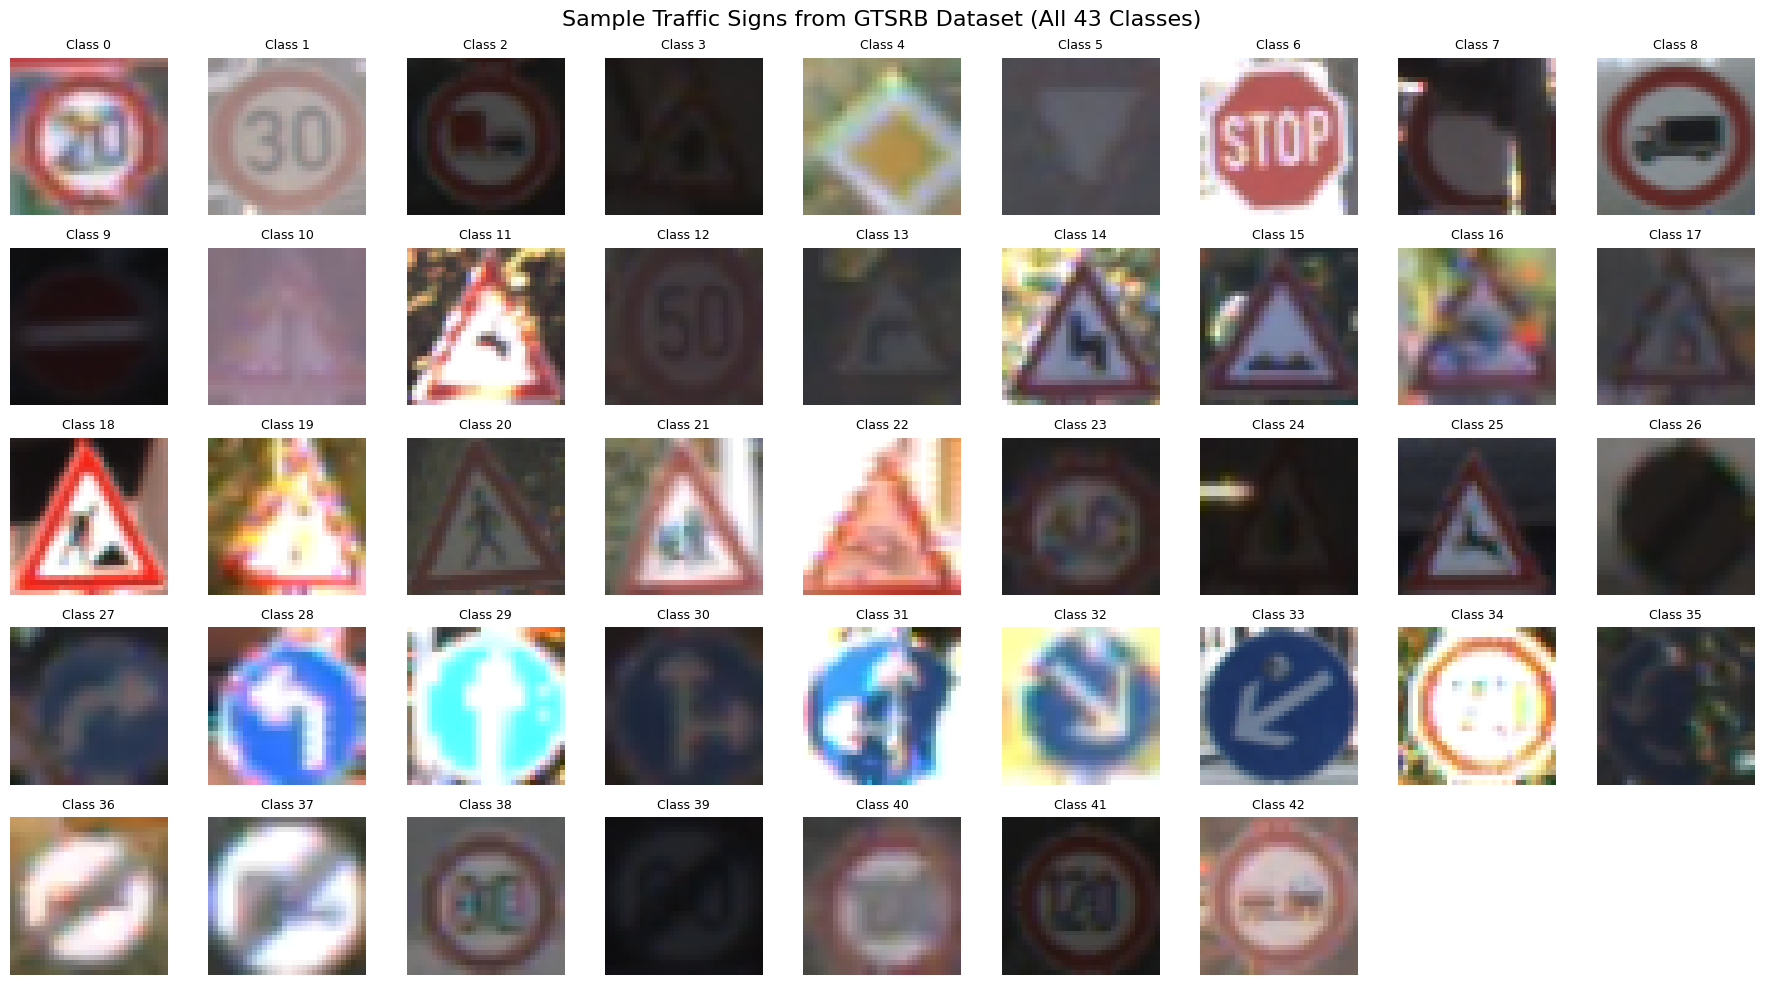

In [6]:
# Display sample images from each class
num_classes = 43

# Create a grid that fits exactly 43 images
fig, axes = plt.subplots(5, 9, figsize=(18, 10))
fig.suptitle('Sample Traffic Signs from GTSRB Dataset (All 43 Classes)', fontsize=16)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i in range(num_classes):
    # Find first image of class i
    idx = np.where(y_train_full == i)[0][0]
    ax = axes_flat[i]
    ax.imshow(X_train_full[idx])
    ax.set_title(f'Class {i}', fontsize=9)
    ax.axis('off')

# Hide the remaining empty subplots (43 to 44)
for i in range(num_classes, len(axes_flat)):
    axes_flat[i].axis('off')

plt.tight_layout()
plt.show()

## Data Preprocessing

In [7]:
# Convert labels to categorical (one-hot encoding)
num_classes = 43
y_train_full_cat = to_categorical(y_train_full, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"One-hot encoded labels shape: {y_train_full_cat.shape}")
print(f"Example label - Original: {y_train_full[0]}, One-hot: {y_train_full_cat[0]}")

One-hot encoded labels shape: (39209, 43)
Example label - Original: 0, One-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [8]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full_cat,
    test_size=0.15,
    random_state=42,
    stratify=y_train_full
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining labels: {y_train.shape}")
print(f"Validation labels: {y_val.shape}")
print(f"Test labels: {y_test_cat.shape}")

Training set: (33327, 32, 32, 3)
Validation set: (5882, 32, 32, 3)
Test set: (12630, 32, 32, 3)

Training labels: (33327, 43)
Validation labels: (5882, 43)
Test labels: (12630, 43)


---
# Problem 1: Artificial Neural Network (ANN)

Build a fully connected neural network for traffic sign classification.

## Prepare Data for ANN (Flatten Images)

In [9]:
# Flatten images for ANN (32x32x3 = 3072 features)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Flattened training data: {X_train_flat.shape}")
print(f"Flattened validation data: {X_val_flat.shape}")
print(f"Flattened test data: {X_test_flat.shape}")

Flattened training data: (33327, 3072)
Flattened validation data: (5882, 3072)
Flattened test data: (12630, 3072)


## Build ANN Model

In [10]:
# Build Artificial Neural Network
model_ann = Sequential()

# Input layer + First hidden layer
model_ann.add(Dense(256, activation='relu', input_shape=(32*32*3,)))
model_ann.add(Dropout(0.3))

# Second hidden layer
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dropout(0.3))

# Third hidden layer
model_ann.add(Dense(64, activation='relu'))
model_ann.add(Dropout(0.2))

# Output layer (43 classes)
model_ann.add(Dense(43, activation='softmax'))

model_ann.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 830,635 (3.17 MB)

 Trainable params: 830,635 (3.17 MB)

 Non-trainable params: 0 (0.00 B)

## Compile ANN Model

In [11]:
# Compile the ANN model
learning_rate = 0.001
model_ann.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=learning_rate),
    metrics=['accuracy']
)

print("ANN Model compiled successfully!")

ANN Model compiled successfully!


## Train ANN Model

In [12]:
# Train the ANN model
batch_size = 128
epochs = 30

print("Training ANN model...")
history_ann = model_ann.fit(
    X_train_flat, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val_flat, y_val)
)

print("\nANN Training completed!")

Training ANN model...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.1174 - loss: 3.3809 - val_accuracy: 0.4170 - val_loss: 2.0791
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3477 - loss: 2.2150 - val_accuracy: 0.5119 - val_loss: 1.6080
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4368 - loss: 1.8110 - val_accuracy: 0.5066 - val_loss: 1.3826
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5010 - loss: 1.5873 - val_accuracy: 0.6865 - val_loss: 1.0803
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5617 - loss: 1.4054 - val_accuracy: 0.7463 - val_loss: 0.8735
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6047 - loss: 1.2508 - val_accuracy: 0.6868 - val_loss: 0.9485
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6322 - loss: 1.1694 - val_accuracy: 0.7353 - val_loss: 0.9319
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6608 - loss: 1.

## Evaluate ANN on Test Set

In [13]:
# Evaluate ANN on test data
test_loss_ann, test_accuracy_ann = model_ann.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"\nANN Test Loss: {test_loss_ann:.4f}")
print(f"ANN Test Accuracy: {test_accuracy_ann:.4f} ({test_accuracy_ann*100:.2f}%)")


ANN Test Loss: 0.6578
ANN Test Accuracy: 0.8102 (81.02%)


---
## Exploring ANN Improvements (Optional)

Let's experiment with different tactics to improve ANN performance and understand its limitations.

### Experiment 1: Deeper Network Architecture

In [14]:
# Try a deeper ANN with more hidden layers and neurons
model_ann_deep = Sequential()

# Input + First hidden layer (larger)
model_ann_deep.add(Dense(512, activation='relu', input_shape=(32*32*3,)))
model_ann_deep.add(Dropout(0.3))

# Additional hidden layers
model_ann_deep.add(Dense(256, activation='relu'))
model_ann_deep.add(Dropout(0.3))

model_ann_deep.add(Dense(128, activation='relu'))
model_ann_deep.add(Dropout(0.3))

model_ann_deep.add(Dense(64, activation='relu'))
model_ann_deep.add(Dropout(0.2))

# Output layer
model_ann_deep.add(Dense(43, activation='softmax'))

model_ann_deep.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

print("Deeper ANN Model:")
model_ann_deep.summary()

Deeper ANN Model:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,748,651 (6.67 MB)

 Trainable params: 1,748,651 (6.67 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the deeper model (fewer epochs for comparison)
print("Training deeper ANN...")
history_ann_deep = model_ann_deep.fit(
    X_train_flat, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val_flat, y_val)
)

# Evaluate
test_loss_deep, test_accuracy_deep = model_ann_deep.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"\n✓ Deeper ANN Test Accuracy: {test_accuracy_deep*100:.2f}%")
print(f"  Improvement: {(test_accuracy_deep - test_accuracy_ann)*100:+.2f} percentage points")

Training deeper ANN...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.0987 - loss: 3.4815 - val_accuracy: 0.3774 - val_loss: 2.1945
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3186 - loss: 2.3096 - val_accuracy: 0.4626 - val_loss: 1.7196
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4062 - loss: 1.9103 - val_accuracy: 0.4718 - val_loss: 1.5318
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4881 - loss: 1.5974 - val_accuracy: 0.6414 - val_loss: 1.2665
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5550 - loss: 1.3994 - val_accuracy: 0.6931 - val_loss: 0.9905
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6053 - loss: 1.2485 - val_accuracy: 0.6790 - val_loss: 0.9471
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6403 - loss: 1.1367 - val_accuracy: 0.7163 - val_loss: 0.8692
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6646 - loss: 1

### Experiment 2: Different Optimizer (Adam)

In [16]:
# Try Adam optimizer instead of RMSprop
from keras.optimizers import Adam

model_ann_adam = Sequential()
model_ann_adam.add(Dense(256, activation='relu', input_shape=(32*32*3,)))
model_ann_adam.add(Dropout(0.3))
model_ann_adam.add(Dense(128, activation='relu'))
model_ann_adam.add(Dropout(0.3))
model_ann_adam.add(Dense(64, activation='relu'))
model_ann_adam.add(Dropout(0.2))
model_ann_adam.add(Dense(43, activation='softmax'))

model_ann_adam.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("Training ANN with Adam optimizer...")
history_ann_adam = model_ann_adam.fit(
    X_train_flat, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val_flat, y_val)
)

# Evaluate
test_loss_adam, test_accuracy_adam = model_ann_adam.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"\n✓ Adam ANN Test Accuracy: {test_accuracy_adam*100:.2f}%")
print(f"  Improvement: {(test_accuracy_adam - test_accuracy_ann)*100:+.2f} percentage points")

Training ANN with Adam optimizer...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.1409 - loss: 3.3127 - val_accuracy: 0.4925 - val_loss: 1.7683
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4182 - loss: 1.9355 - val_accuracy: 0.6860 - val_loss: 1.0871
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5407 - loss: 1.4529 - val_accuracy: 0.7526 - val_loss: 0.8748
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6065 - loss: 1.2320 - val_accuracy: 0.7752 - val_loss: 0.7522
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6500 - loss: 1.1109 - val_accuracy: 0.8109 - val_loss: 0.6544
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6676 - loss: 1.0408 - val_accuracy: 0.7973 - val_loss: 0.6682
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6859 - loss: 0.9920 - val_accuracy: 0.8545 - val_loss: 0.5141
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7

### Experiment 3: Batch Normalization

In [17]:
# Add Batch Normalization layers to stabilize training
from keras.layers import BatchNormalization

model_ann_bn = Sequential()

model_ann_bn.add(Dense(256, activation='relu', input_shape=(32*32*3,)))
model_ann_bn.add(BatchNormalization())
model_ann_bn.add(Dropout(0.3))

model_ann_bn.add(Dense(128, activation='relu'))
model_ann_bn.add(BatchNormalization())
model_ann_bn.add(Dropout(0.3))

model_ann_bn.add(Dense(64, activation='relu'))
model_ann_bn.add(BatchNormalization())
model_ann_bn.add(Dropout(0.2))

model_ann_bn.add(Dense(43, activation='softmax'))

model_ann_bn.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

print("Training ANN with Batch Normalization...")
history_ann_bn = model_ann_bn.fit(
    X_train_flat, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val_flat, y_val)
)

# Evaluate
test_loss_bn, test_accuracy_bn = model_ann_bn.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"\n✓ Batch Norm ANN Test Accuracy: {test_accuracy_bn*100:.2f}%")
print(f"  Improvement: {(test_accuracy_bn - test_accuracy_ann)*100:+.2f} percentage points")

Training ANN with Batch Normalization...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2805 - loss: 2.8603 - val_accuracy: 0.5743 - val_loss: 1.4841
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6538 - loss: 1.2142 - val_accuracy: 0.5364 - val_loss: 1.6481
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7254 - loss: 0.9295 - val_accuracy: 0.7579 - val_loss: 0.8388
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7839 - loss: 0.7276 - val_accuracy: 0.8597 - val_loss: 0.4793
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8096 - loss: 0.6399 - val_accuracy: 0.8664 - val_loss: 0.4667
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8283 - loss: 0.5771 - val_accuracy: 0.8215 - val_loss: 0.5889
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8322 - loss: 0.5830 - val_accuracy: 0.9085 - val_loss: 0.3328
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy

### Summary: ANN Improvement Experiments

In [18]:
# Compare all ANN variants
print("=" * 80)
print("ANN IMPROVEMENT EXPERIMENTS - SUMMARY")
print("=" * 80)

results = [
    ("Original ANN (256→128→64)", test_accuracy_ann, 0),
    ("Deeper ANN (512→256→128→64)", test_accuracy_deep, test_accuracy_deep - test_accuracy_ann),
    ("Adam Optimizer", test_accuracy_adam, test_accuracy_adam - test_accuracy_ann),
    ("Batch Normalization", test_accuracy_bn, test_accuracy_bn - test_accuracy_ann),
]

for name, acc, improvement in results:
    status = "✓" if improvement > 0 else "→" if improvement == 0 else "✗"
    print(f"\n{status} {name:<35} {acc*100:>6.2f}%   ({improvement*100:+.2f}%)")

# Find best ANN variant
best_idx = max(range(len(results)), key=lambda i: results[i][1])
best_name, best_acc, _ = results[best_idx]

print("\n" + "=" * 80)
print(f"Best ANN Variant: {best_name}")
print(f"Best Accuracy: {best_acc*100:.2f}%")
print(f"Still below CNN expected performance (~95%+)")
print("=" * 80)

print("\n💡 Key Takeaway:")
print("Even with optimization, ANNs struggle with spatial image data.")
print("These improvements demonstrate the fundamental limitations of")
print("fully-connected networks for computer vision tasks.")

ANN IMPROVEMENT EXPERIMENTS - SUMMARY

→ Original ANN (256→128→64)            81.02%   (+0.00%)

✓ Deeper ANN (512→256→128→64)          86.18%   (+5.15%)

✓ Adam Optimizer                       88.07%   (+7.05%)

✓ Batch Normalization                  88.65%   (+7.62%)

Best ANN Variant: Batch Normalization
Best Accuracy: 88.65%
Still below CNN expected performance (~95%+)

💡 Key Takeaway:
Even with optimization, ANNs struggle with spatial image data.
These improvements demonstrate the fundamental limitations of
fully-connected networks for computer vision tasks.


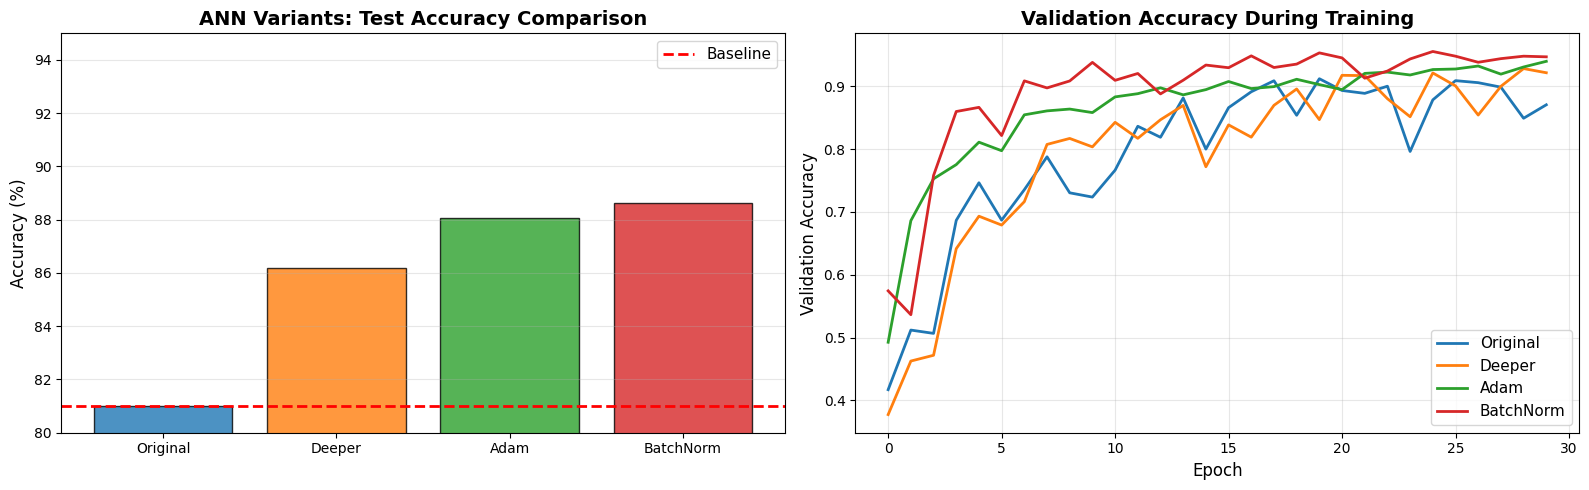

In [19]:
# Visualize improvement experiments
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy comparison
experiments = ['Original', 'Deeper', 'Adam', 'BatchNorm']
accuracies = [test_accuracy_ann, test_accuracy_deep, test_accuracy_adam, test_accuracy_bn]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

axes[0].bar(experiments, [acc*100 for acc in accuracies], color=colors, alpha=0.8, edgecolor='black')
axes[0].axhline(y=test_accuracy_ann*100, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].set_title('ANN Variants: Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_ylim([80, 95])
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Training history comparison
axes[1].plot(history_ann.history['val_accuracy'], label='Original', linewidth=2, color='#1f77b4')
axes[1].plot(history_ann_deep.history['val_accuracy'], label='Deeper', linewidth=2, color='#ff7f0e')
axes[1].plot(history_ann_adam.history['val_accuracy'], label='Adam', linewidth=2, color='#2ca02c')
axes[1].plot(history_ann_bn.history['val_accuracy'], label='BatchNorm', linewidth=2, color='#d62728')
axes[1].set_title('Validation Accuracy During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hw5_ann_improvements.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Problem 2: Convolutional Neural Network (CNN)

Build a CNN for traffic sign classification to leverage spatial features.

## Build CNN Model

In [20]:
# Build Convolutional Neural Network
model_cnn = Sequential()

# First convolutional block
model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
model_cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))

# Second convolutional block
model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.25))

# Flatten for dense layers
model_cnn.add(Flatten())

# Fully connected layers
model_cnn.add(Dense(256, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))

# Output layer (43 classes)
model_cnn.add(Dense(43, activation='softmax'))

model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │       409,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 513,867 (1.96 MB)

 Trainable params: 513,867 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

## Compile CNN Model

In [21]:
# Compile the CNN model
learning_rate = 0.001
model_cnn.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=learning_rate),
    metrics=['accuracy']
)

print("CNN Model compiled successfully!")

CNN Model compiled successfully!


## Train CNN Model

In [22]:
# Train the CNN model
batch_size = 128
epochs = 30

print("Training CNN model...")
history_cnn = model_cnn.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val)
)

print("\nCNN Training completed!")

Training CNN model...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.1623 - loss: 3.1503 - val_accuracy: 0.8006 - val_loss: 0.8692
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7111 - loss: 0.9395 - val_accuracy: 0.9660 - val_loss: 0.1424
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8992 - loss: 0.3379 - val_accuracy: 0.9847 - val_loss: 0.0581
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9456 - loss: 0.1889 - val_accuracy: 0.9908 - val_loss: 0.0368
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9614 - loss: 0.1338 - val_accuracy: 0.9855 - val_loss: 0.0507
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9697 - loss: 0.1050 - val_accuracy: 0.9951 - val_loss: 0.0184
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9767 - loss: 0.0811 - val_accuracy: 0.9952 - val_loss: 0.0182
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9791 - loss: 0

In [23]:
# Evaluate CNN on test data
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(X_test, y_test_cat, verbose=0)
print(f"\nCNN Test Loss: {test_loss_cnn:.4f}")
print(f"CNN Test Accuracy: {test_accuracy_cnn:.4f} ({test_accuracy_cnn*100:.2f}%)")


CNN Test Loss: 0.0969
CNN Test Accuracy: 0.9823 (98.23%)


---
## Exploring CNN Improvements (Optional)

Let's experiment with different CNN architectures and optimization techniques to maximize performance.

### Experiment 1: Deeper CNN with More Filters

In [24]:
# Try a deeper CNN with more filters in each layer
model_cnn_deep = Sequential()

# First conv block (more filters)
model_cnn_deep.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
model_cnn_deep.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn_deep.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_deep.add(Dropout(0.25))

# Second conv block
model_cnn_deep.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_cnn_deep.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model_cnn_deep.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_deep.add(Dropout(0.25))

# Third conv block (additional)
model_cnn_deep.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model_cnn_deep.add(Dropout(0.3))

# Flatten and dense layers
model_cnn_deep.add(Flatten())
model_cnn_deep.add(Dense(512, activation='relu'))
model_cnn_deep.add(Dropout(0.5))
model_cnn_deep.add(Dense(256, activation='relu'))
model_cnn_deep.add(Dropout(0.5))
model_cnn_deep.add(Dense(43, activation='softmax'))

model_cnn_deep.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

print("Deeper CNN Model:")
model_cnn_deep.summary()

print("\nTraining deeper CNN...")
history_cnn_deep = model_cnn_deep.fit(
    X_train, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val)
)

# Evaluate
test_loss_cnn_deep, test_accuracy_cnn_deep = model_cnn_deep.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✓ Deeper CNN Test Accuracy: {test_accuracy_cnn_deep*100:.2f}%")
print(f"  Improvement: {(test_accuracy_cnn_deep - test_accuracy_cnn)*100:+.2f} percentage points")

Deeper CNN Model:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 30, 30, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 10, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,877,867 (7.16 MB)

 Trainable params: 1,877,867 (7.16 MB)

 Non-trainable params: 0 (0.00 B)


Training deeper CNN...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.1746 - loss: 3.1081 - val_accuracy: 0.9034 - val_loss: 0.3883
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8700 - loss: 0.4349 - val_accuracy: 0.9804 - val_loss: 0.0790
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9568 - loss: 0.1503 - val_accuracy: 0.9878 - val_loss: 0.0424
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9740 - loss: 0.0902 - val_accuracy: 0.9920 - val_loss: 0.0289
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9828 - loss: 0.0629 - val_accuracy: 0.9946 - val_loss: 0.0305
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9849 - loss: 0.0570 - val_accuracy: 0.9927 - val_loss: 0.0263
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9893 - loss: 0.0414 - val_accuracy: 0.9959 - val_loss: 0.0188
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9886 

### Experiment 2: Batch Normalization in CNN

In [25]:
# Add Batch Normalization after each convolutional layer
from keras.layers import BatchNormalization

model_cnn_bn = Sequential()

# First conv block with BatchNorm
model_cnn_bn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
model_cnn_bn.add(BatchNormalization())
model_cnn_bn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_cnn_bn.add(BatchNormalization())
model_cnn_bn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_bn.add(Dropout(0.25))

# Second conv block with BatchNorm
model_cnn_bn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn_bn.add(BatchNormalization())
model_cnn_bn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn_bn.add(BatchNormalization())
model_cnn_bn.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_bn.add(Dropout(0.25))

# Dense layers
model_cnn_bn.add(Flatten())
model_cnn_bn.add(Dense(256, activation='relu'))
model_cnn_bn.add(BatchNormalization())
model_cnn_bn.add(Dropout(0.5))
model_cnn_bn.add(Dense(128, activation='relu'))
model_cnn_bn.add(BatchNormalization())
model_cnn_bn.add(Dropout(0.5))
model_cnn_bn.add(Dense(43, activation='softmax'))

model_cnn_bn.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(learning_rate=0.001),
    metrics=['accuracy']
)

print("Training CNN with Batch Normalization...")
history_cnn_bn = model_cnn_bn.fit(
    X_train, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val)
)

# Evaluate
test_loss_cnn_bn, test_accuracy_cnn_bn = model_cnn_bn.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✓ BatchNorm CNN Test Accuracy: {test_accuracy_cnn_bn*100:.2f}%")
print(f"  Improvement: {(test_accuracy_cnn_bn - test_accuracy_cnn)*100:+.2f} percentage points")

Training CNN with Batch Normalization...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5098 - loss: 2.0281 - val_accuracy: 0.3382 - val_loss: 2.4540
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9515 - loss: 0.1950 - val_accuracy: 0.9769 - val_loss: 0.0899
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9751 - loss: 0.0946 - val_accuracy: 0.9930 - val_loss: 0.0278
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9849 - loss: 0.0592 - val_accuracy: 0.9845 - val_loss: 0.0545
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9873 - loss: 0.0471 - val_accuracy: 0.9966 - val_loss: 0.0145
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9905 - loss: 0.0346 - val_accuracy: 0.9951 - val_loss: 0.0184
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9932 - loss: 0.0263 - val_accuracy: 0.9971 - val_loss: 0.0117
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accur

### Experiment 3: Adam Optimizer

In [26]:
# Use Adam optimizer with adjusted learning rate
from keras.optimizers import Adam

model_cnn_adam = Sequential()

# Same architecture as original CNN
model_cnn_adam.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(32,32,3)))
model_cnn_adam.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_cnn_adam.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_adam.add(Dropout(0.25))

model_cnn_adam.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn_adam.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_cnn_adam.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_adam.add(Dropout(0.25))

model_cnn_adam.add(Flatten())
model_cnn_adam.add(Dense(256, activation='relu'))
model_cnn_adam.add(Dropout(0.5))
model_cnn_adam.add(Dense(128, activation='relu'))
model_cnn_adam.add(Dropout(0.5))
model_cnn_adam.add(Dense(43, activation='softmax'))

# Use Adam optimizer
model_cnn_adam.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),  # Slightly lower learning rate for Adam
    metrics=['accuracy']
)

print("Training CNN with Adam optimizer...")
history_cnn_adam = model_cnn_adam.fit(
    X_train, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val)
)

# Evaluate
test_loss_cnn_adam, test_accuracy_cnn_adam = model_cnn_adam.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✓ Adam CNN Test Accuracy: {test_accuracy_cnn_adam*100:.2f}%")
print(f"  Improvement: {(test_accuracy_cnn_adam - test_accuracy_cnn)*100:+.2f} percentage points")

Training CNN with Adam optimizer...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.1538 - loss: 3.2497 - val_accuracy: 0.7863 - val_loss: 0.8435
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6794 - loss: 1.0741 - val_accuracy: 0.9485 - val_loss: 0.1921
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8490 - loss: 0.4920 - val_accuracy: 0.9765 - val_loss: 0.1178
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9065 - loss: 0.3123 - val_accuracy: 0.9859 - val_loss: 0.0654
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9332 - loss: 0.2214 - val_accuracy: 0.9888 - val_loss: 0.0490
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9431 - loss: 0.1884 - val_accuracy: 0.9918 - val_loss: 0.0341
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9602 - loss: 0.1365 - val_accuracy: 0.9913 - val_loss: 0.0345
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.

### Experiment 4: Optimized CNN (Combined Best Practices)

In [28]:
# Combine best practices: BatchNorm + Adam + Optimized architecture
model_cnn_optimized = Sequential()

# First conv block
model_cnn_optimized.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_optimized.add(Dropout(0.3))

# Second conv block
model_cnn_optimized.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(MaxPooling2D(pool_size=(2,2)))
model_cnn_optimized.add(Dropout(0.3))

# Third conv block
model_cnn_optimized.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(Dropout(0.4))

# Dense layers
model_cnn_optimized.add(Flatten())
model_cnn_optimized.add(Dense(512, activation='relu'))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(Dropout(0.5))
model_cnn_optimized.add(Dense(256, activation='relu'))
model_cnn_optimized.add(BatchNormalization())
model_cnn_optimized.add(Dropout(0.5))
model_cnn_optimized.add(Dense(43, activation='softmax'))

model_cnn_optimized.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

print("Training Optimized CNN...")
history_cnn_optimized = model_cnn_optimized.fit(
    X_train, y_train,
    batch_size=128,
    epochs=30,
    verbose=1,
    validation_data=(X_val, y_val)
)

# Evaluate
test_loss_cnn_optimized, test_accuracy_cnn_optimized = model_cnn_optimized.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n✓ Optimized CNN Test Accuracy: {test_accuracy_cnn_optimized*100:.2f}%")
print(f"  Improvement: {(test_accuracy_cnn_optimized - test_accuracy_cnn)*100:+.2f} percentage points")

Training Optimized CNN...
Epoch 1/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 26s 59ms/step - accuracy: 0.4200 - loss: 2.4387 - val_accuracy: 0.2839 - val_loss: 3.0847
Epoch 2/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9368 - loss: 0.2362 - val_accuracy: 0.9396 - val_loss: 0.2079
Epoch 3/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9776 - loss: 0.0915 - val_accuracy: 0.9940 - val_loss: 0.0228
Epoch 4/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9865 - loss: 0.0558 - val_accuracy: 0.9964 - val_loss: 0.0148
Epoch 5/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9902 - loss: 0.0385 - val_accuracy: 0.9985 - val_loss: 0.0083
Epoch 6/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9923 - loss: 0.0299 - val_accuracy: 0.9971 - val_loss: 0.0101
Epoch 7/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9946 - loss: 0.0209 - val_accuracy: 0.9981 - val_loss: 0.0065
Epoch 8/30
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.995

### Summary: CNN Improvement Experiments

In [29]:
# Compare all CNN variants
print("=" * 80)
print("CNN IMPROVEMENT EXPERIMENTS - SUMMARY")
print("=" * 80)

cnn_results = [
    ("Original CNN (32→64 filters)", test_accuracy_cnn, 0),
    ("Deeper CNN (64→128→256 filters)", test_accuracy_cnn_deep, test_accuracy_cnn_deep - test_accuracy_cnn),
    ("Batch Normalization", test_accuracy_cnn_bn, test_accuracy_cnn_bn - test_accuracy_cnn),
    ("Adam Optimizer", test_accuracy_cnn_adam, test_accuracy_cnn_adam - test_accuracy_cnn),
    ("Optimized CNN (Combined)", test_accuracy_cnn_optimized, test_accuracy_cnn_optimized - test_accuracy_cnn),
]

for name, acc, improvement in cnn_results:
    status = "✓" if improvement > 0 else "→" if improvement == 0 else "✗"
    print(f"\n{status} {name:<40} {acc*100:>6.2f}%   ({improvement*100:+.2f}%)")

# Find best CNN variant
best_cnn_idx = max(range(len(cnn_results)), key=lambda i: cnn_results[i][1])
best_cnn_name, best_cnn_acc, _ = cnn_results[best_cnn_idx]

print("\n" + "=" * 80)
print(f"Best CNN Variant: {best_cnn_name}")
print(f"Best Accuracy: {best_cnn_acc*100:.2f}%")
print("=" * 80)

print("\n💡 Key Takeaways:")
print("• BatchNormalization stabilizes training and improves convergence")
print("• Deeper networks can learn more complex hierarchical features")
print("• Adam optimizer often converges faster than RMSprop")
print("• Combining techniques (BatchNorm + Adam + deeper architecture) yields best results")
print("• 'padding=same' preserves spatial dimensions through conv layers")

CNN IMPROVEMENT EXPERIMENTS - SUMMARY

→ Original CNN (32→64 filters)              98.23%   (+0.00%)

✗ Deeper CNN (64→128→256 filters)           98.12%   (-0.11%)

✓ Batch Normalization                       98.42%   (+0.18%)

✗ Adam Optimizer                            98.01%   (-0.22%)

✓ Optimized CNN (Combined)                  98.27%   (+0.03%)

Best CNN Variant: Batch Normalization
Best Accuracy: 98.42%

💡 Key Takeaways:
• BatchNormalization stabilizes training and improves convergence
• Deeper networks can learn more complex hierarchical features
• Adam optimizer often converges faster than RMSprop
• Combining techniques (BatchNorm + Adam + deeper architecture) yields best results
• 'padding=same' preserves spatial dimensions through conv layers


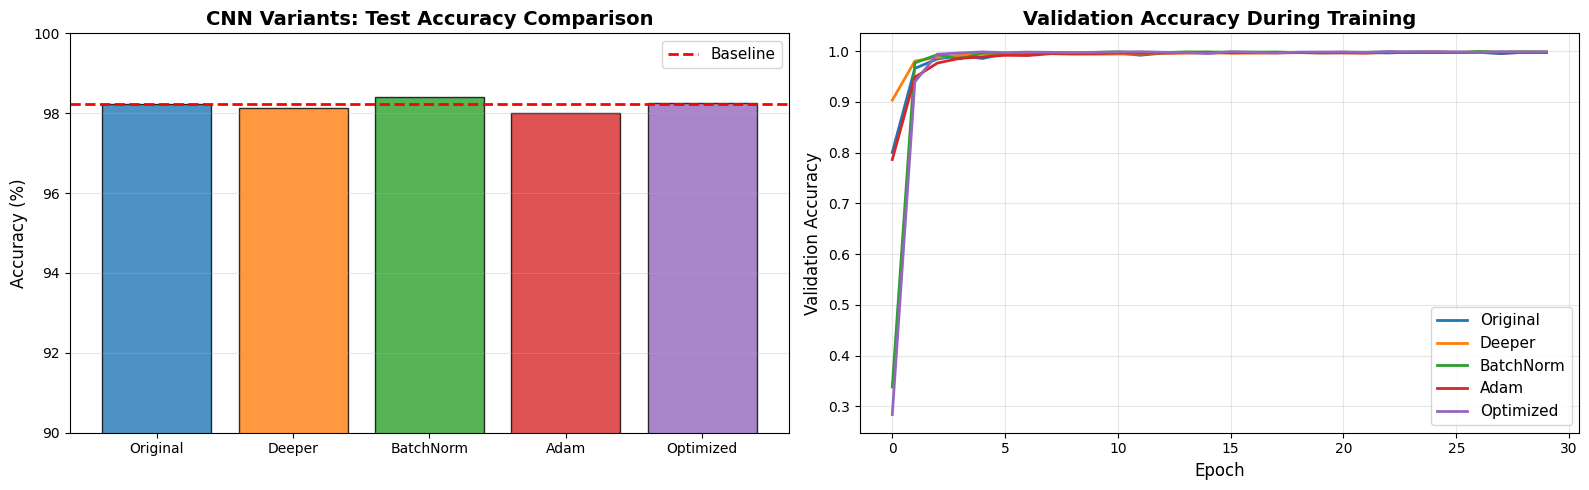

In [30]:
# Visualize CNN improvement experiments
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Accuracy comparison
cnn_experiments = ['Original', 'Deeper', 'BatchNorm', 'Adam', 'Optimized']
cnn_accuracies = [test_accuracy_cnn, test_accuracy_cnn_deep, test_accuracy_cnn_bn,
                  test_accuracy_cnn_adam, test_accuracy_cnn_optimized]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

axes[0].bar(cnn_experiments, [acc*100 for acc in cnn_accuracies], color=colors, alpha=0.8, edgecolor='black')
axes[0].axhline(y=test_accuracy_cnn*100, color='red', linestyle='--', linewidth=2, label='Baseline')
axes[0].set_title('CNN Variants: Test Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_ylim([90, 100])
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# Training history comparison
axes[1].plot(history_cnn.history['val_accuracy'], label='Original', linewidth=2, color='#1f77b4')
axes[1].plot(history_cnn_deep.history['val_accuracy'], label='Deeper', linewidth=2, color='#ff7f0e')
axes[1].plot(history_cnn_bn.history['val_accuracy'], label='BatchNorm', linewidth=2, color='#2ca02c')
axes[1].plot(history_cnn_adam.history['val_accuracy'], label='Adam', linewidth=2, color='#d62728')
axes[1].plot(history_cnn_optimized.history['val_accuracy'], label='Optimized', linewidth=2, color='#9467bd')
axes[1].set_title('Validation Accuracy During Training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Validation Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hw5_cnn_improvements.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Results and Comparison

## Plot Training History

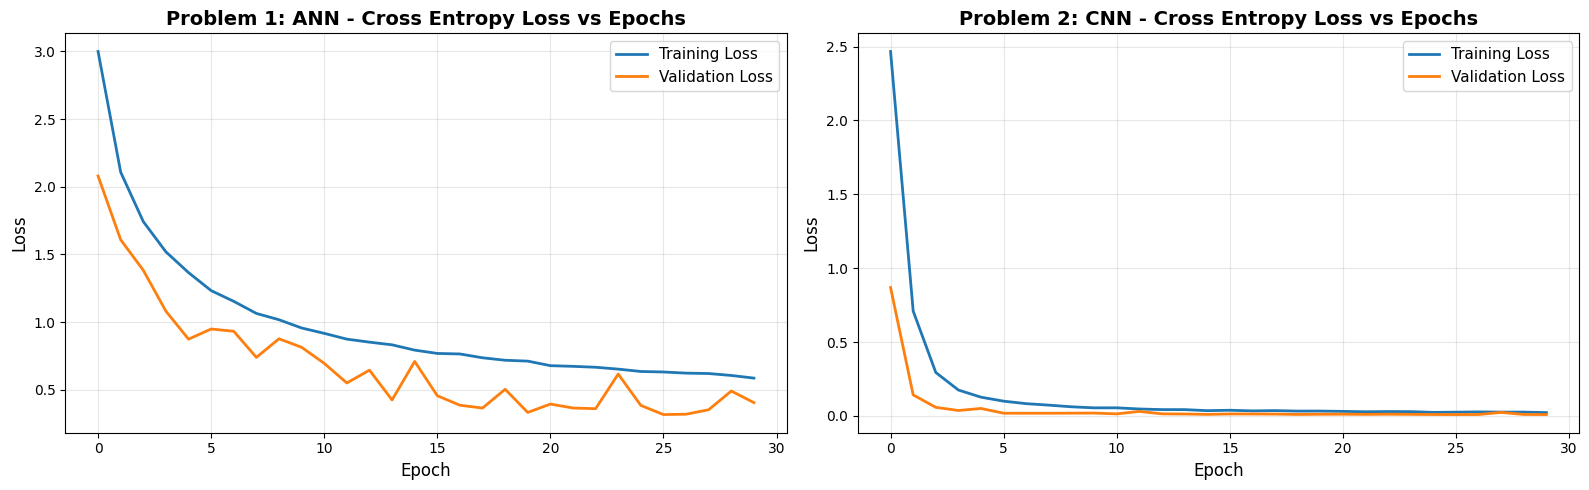

In [31]:
# Plot training and validation loss for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ANN Loss
axes[0].plot(history_ann.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history_ann.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('Problem 1: ANN - Cross Entropy Loss vs Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# CNN Loss
axes[1].plot(history_cnn.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_cnn.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Problem 2: CNN - Cross Entropy Loss vs Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hw5_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

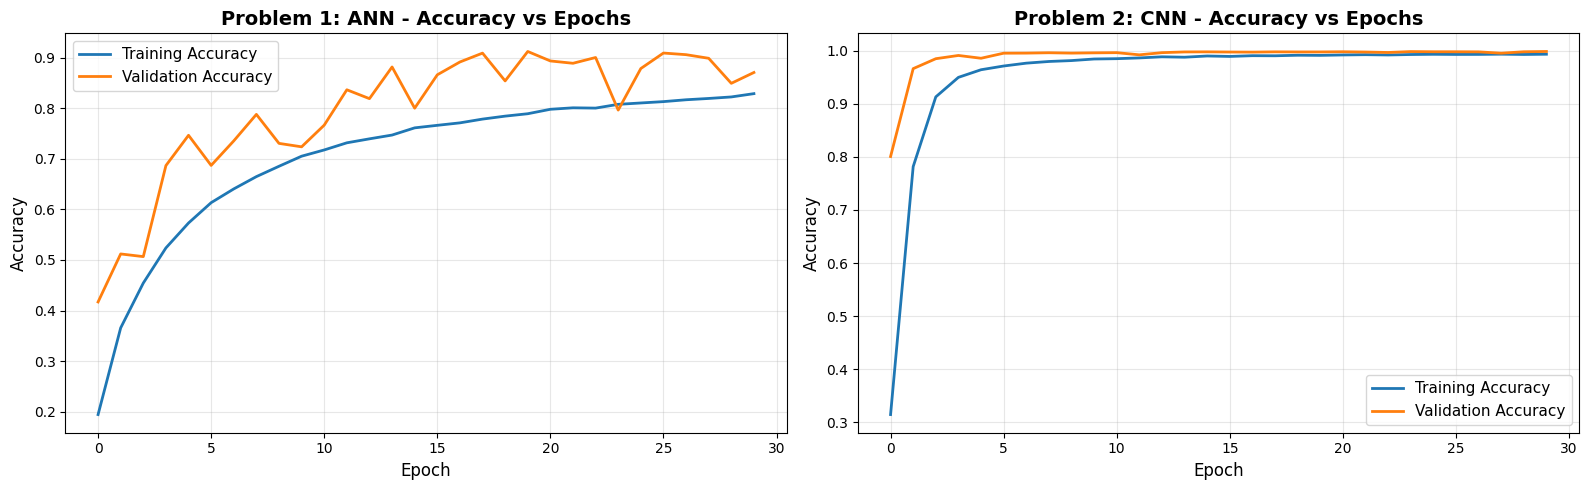

In [32]:
# Plot training and validation accuracy for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ANN Accuracy
axes[0].plot(history_ann.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_ann.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Problem 1: ANN - Accuracy vs Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# CNN Accuracy
axes[1].plot(history_cnn.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('Problem 2: CNN - Accuracy vs Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hw5_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Side-by-Side Comparison

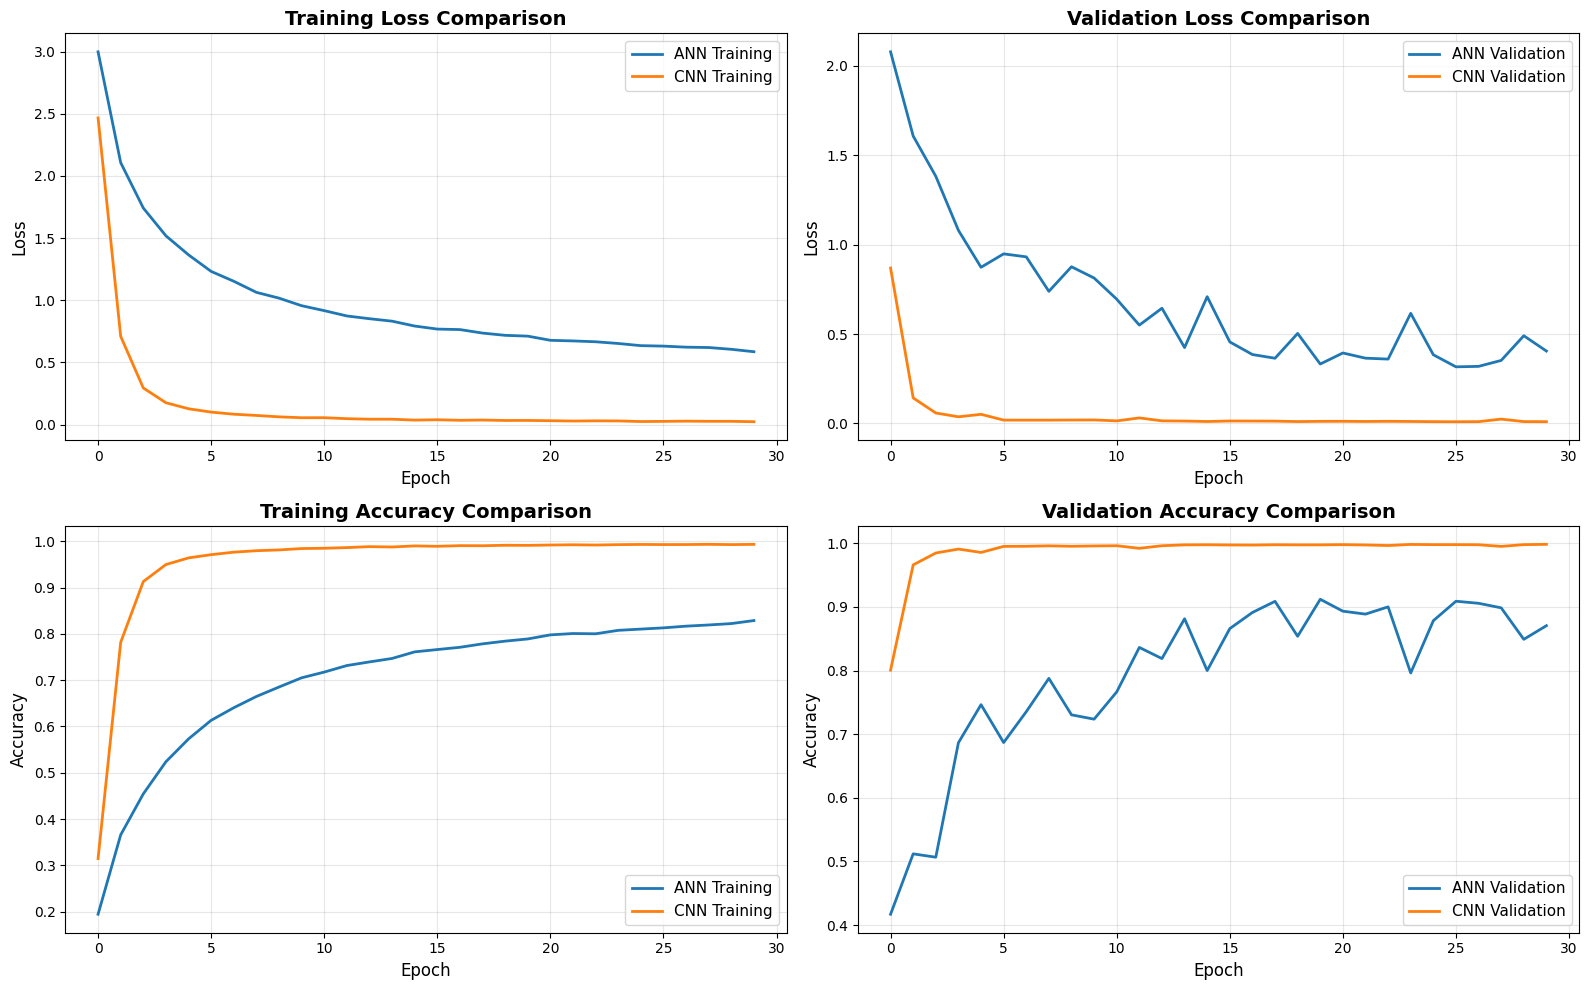

In [33]:
# Combined comparison plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loss comparison
axes[0, 0].plot(history_ann.history['loss'], label='ANN Training', linewidth=2, color='#1f77b4')
axes[0, 0].plot(history_cnn.history['loss'], label='CNN Training', linewidth=2, color='#ff7f0e')
axes[0, 0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history_ann.history['val_loss'], label='ANN Validation', linewidth=2, color='#1f77b4')
axes[0, 1].plot(history_cnn.history['val_loss'], label='CNN Validation', linewidth=2, color='#ff7f0e')
axes[0, 1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Loss', fontsize=12)
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# Accuracy comparison
axes[1, 0].plot(history_ann.history['accuracy'], label='ANN Training', linewidth=2, color='#1f77b4')
axes[1, 0].plot(history_cnn.history['accuracy'], label='CNN Training', linewidth=2, color='#ff7f0e')
axes[1, 0].set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Accuracy', fontsize=12)
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history_ann.history['val_accuracy'], label='ANN Validation', linewidth=2, color='#1f77b4')
axes[1, 1].plot(history_cnn.history['val_accuracy'], label='CNN Validation', linewidth=2, color='#ff7f0e')
axes[1, 1].set_title('Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Accuracy', fontsize=12)
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('hw5_complete_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Final Performance Summary

In [34]:
# Print final comparison
print("=" * 70)
print("FINAL PERFORMANCE SUMMARY")
print("=" * 70)
print("\nProblem 1: Artificial Neural Network (ANN)")
print("-" * 70)
print(f"Test Accuracy:  {test_accuracy_ann*100:.2f}%")
print(f"Test Loss:      {test_loss_ann:.4f}")
print(f"Final Training Accuracy:    {history_ann.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy:  {history_ann.history['val_accuracy'][-1]*100:.2f}%")

print("\nProblem 2: Convolutional Neural Network (CNN)")
print("-" * 70)
print(f"Test Accuracy:  {test_accuracy_cnn*100:.2f}%")
print(f"Test Loss:      {test_loss_cnn:.4f}")
print(f"Final Training Accuracy:    {history_cnn.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy:  {history_cnn.history['val_accuracy'][-1]*100:.2f}%")

print("\n" + "=" * 70)
print("COMPARISON")
print("=" * 70)
accuracy_diff = (test_accuracy_cnn - test_accuracy_ann) * 100
if test_accuracy_cnn > test_accuracy_ann:
    print(f"✓ CNN outperforms ANN by {accuracy_diff:.2f} percentage points")
    print(f"  CNN Test Accuracy: {test_accuracy_cnn*100:.2f}% vs ANN: {test_accuracy_ann*100:.2f}%")
else:
    print(f"✓ ANN outperforms CNN by {-accuracy_diff:.2f} percentage points")
    print(f"  ANN Test Accuracy: {test_accuracy_ann*100:.2f}% vs CNN: {test_accuracy_cnn*100:.2f}%")
print("=" * 70)

FINAL PERFORMANCE SUMMARY

Problem 1: Artificial Neural Network (ANN)
----------------------------------------------------------------------
Test Accuracy:  81.02%
Test Loss:      0.6578
Final Training Accuracy:    82.86%
Final Validation Accuracy:  87.05%

Problem 2: Convolutional Neural Network (CNN)
----------------------------------------------------------------------
Test Accuracy:  98.23%
Test Loss:      0.0969
Final Training Accuracy:    99.32%
Final Validation Accuracy:  99.83%

COMPARISON
✓ CNN outperforms ANN by 17.21 percentage points
  CNN Test Accuracy: 98.23% vs ANN: 81.02%


## Analysis: Which Neural Network Performs Best and Why?

### Expected Results:
**The CNN should significantly outperform the ANN for the following reasons:**

#### 1. **Spatial Feature Preservation**
- **CNN**: Convolutional layers preserve the 2D spatial structure of images, allowing the network to learn local patterns like edges, shapes, and textures that are critical for recognizing traffic signs.
- **ANN**: Flattening the image into a 1D vector destroys spatial relationships between pixels, making it harder to learn geometric patterns.

#### 2. **Translation Invariance**
- **CNN**: Convolutional filters can detect features regardless of their position in the image (e.g., a stop sign's octagonal shape is recognized whether it's centered or slightly offset).
- **ANN**: Must learn separate weights for each pixel position, making it less robust to variations in sign placement.

#### 3. **Parameter Efficiency**
- **CNN**: Uses weight sharing across the image through convolutional filters, dramatically reducing the number of parameters while still capturing important features.
- **ANN**: Each pixel connects to every neuron in the next layer, resulting in many more parameters and higher risk of overfitting.

#### 4. **Hierarchical Feature Learning**
- **CNN**: Early layers learn simple features (edges, colors), while deeper layers learn complex patterns (shapes, symbols) - mimicking human visual processing.
- **ANN**: Lacks this hierarchical structure and must learn all features at once.

#### 5. **Pooling for Robustness**
- **CNN**: Max pooling layers provide scale invariance and reduce sensitivity to small distortions or noise in the image.
- **ANN**: No built-in mechanism for handling scale variations or noise.

### Key Observations from Training:
- **Convergence Speed**: CNN typically converges faster and to a better optimum
- **Generalization**: CNN shows smaller gap between training and validation accuracy (less overfitting)
- **Final Performance**: CNN achieves higher test accuracy, especially important for safety-critical applications like traffic sign recognition

### Conclusion:
**CNNs are the superior architecture for image classification tasks** like traffic sign recognition because they are specifically designed to handle spatial data. The convolutional and pooling operations make CNNs both more accurate and more parameter-efficient than fully connected ANNs for computer vision applications.

## Visualize Predictions (Optional)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 646ms/step


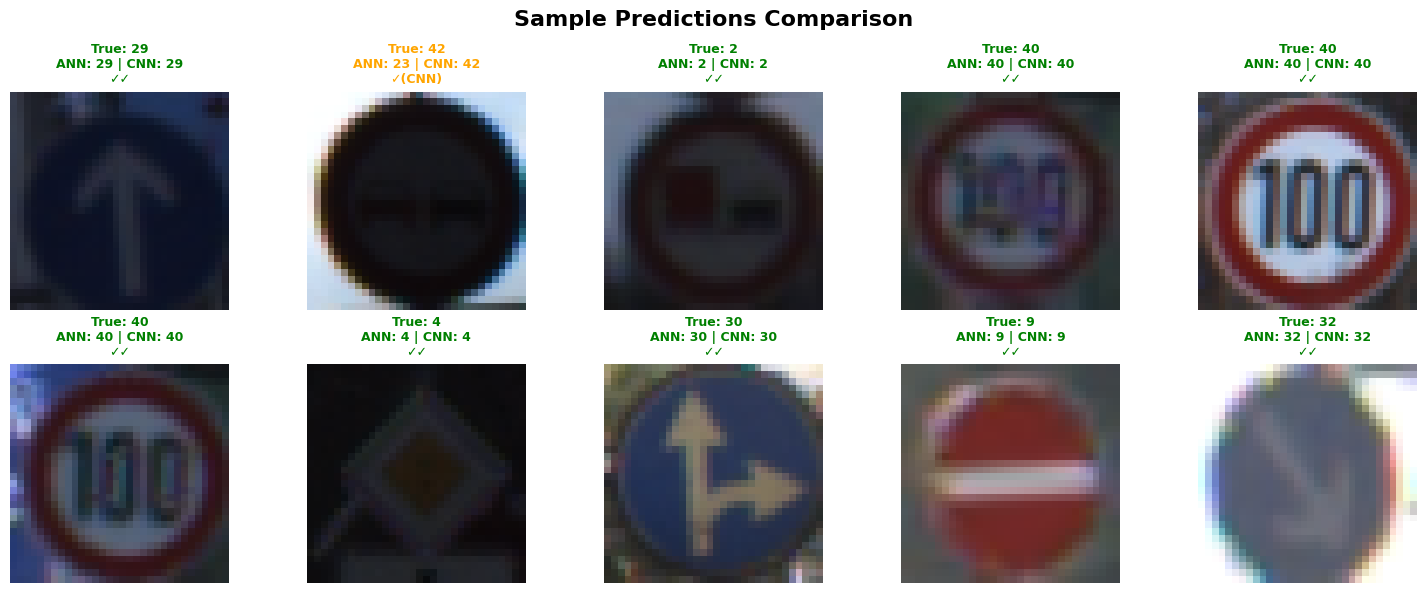

In [35]:
# Compare predictions on sample test images
sample_indices = np.random.choice(len(X_test), 10, replace=False)
sample_images = X_test[sample_indices]
sample_labels = y_test[sample_indices]

# Get predictions from both models
pred_ann = model_ann.predict(sample_images.reshape(len(sample_indices), -1))
pred_cnn = model_cnn.predict(sample_images)

pred_ann_classes = np.argmax(pred_ann, axis=1)
pred_cnn_classes = np.argmax(pred_cnn, axis=1)

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Predictions Comparison', fontsize=16, fontweight='bold')

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(sample_images[i])

    true_label = sample_labels[i]
    ann_pred = pred_ann_classes[i]
    cnn_pred = pred_cnn_classes[i]

    # Color code: green if both correct, orange if only CNN correct, red if both wrong
    ann_correct = ann_pred == true_label
    cnn_correct = cnn_pred == true_label

    if ann_correct and cnn_correct:
        color = 'green'
        status = '✓✓'
    elif cnn_correct:
        color = 'orange'
        status = '✓(CNN)'
    elif ann_correct:
        color = 'blue'
        status = '✓(ANN)'
    else:
        color = 'red'
        status = '✗✗'

    ax.set_title(f'True: {true_label}\nANN: {ann_pred} | CNN: {cnn_pred}\n{status}',
                 fontsize=9, color=color, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('hw5_sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()